## How can we predict survival on the Titanic?

Predict survival on the Titanic using passenger features like age, fare, class, and more. This project includes:
- Exploratory Data Analysis (EDA)
- Feature engineering
- Model training & evaluation
- Final prediction & submission

### Guiding Questions
- Which features are correlated with survival?
- Can we accurately predict survival with a simple model?
- Which model performs best on this dataset?

1. Import Statements

In [755]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score # did i use this?

import warnings

In [756]:
warnings.filterwarnings("ignore")

## Load and Preview Data

Load the Titanic training and test datasets and take an initial look at structure, types, and missing values.

In [757]:
train_df = pd.read_csv('titanic/train.csv')
test_df = pd.read_csv('titanic/test.csv')
print(f"Passengers in train set: {train_df.shape[0]}\nPassengers in test set: {test_df.shape[0]}")

Passengers in train set: 891
Passengers in test set: 418


We have 891 rows in the training set and 418 in the test set — a roughly 7:3 ratio.

In [758]:
print(train_df.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


### Dataset description

| Column | dtype | Description |
|----------|----------|----------|
| PassengerId  | int64  | unique ID to each passenger  |
| Survived  | int64  | Target variable (0 = no, 1 = yes)  |
| Pclass  | int64  | Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)  |
| Name  | object  | Full name - parsed for title, name length  |
| Sex  | object  | Gender (male, female) |
| Age  | float64  | Age in years  |
| SibSp  | int64  | Siblings/spouses aboard  |
| Parch  | int64  | Parents/children aboard  |
| Ticket  | object?  | Ticket number |
| Fare  | float64  | Passenger fare |
| Cabin  | object  | Cabin info (used to infer deck)  |
| Embarked  | object  | Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton) |

In [759]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [760]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [761]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [762]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [763]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [764]:
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [765]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [766]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [767]:
train_df["Embarked"].str[0].unique()
train_df["Cabin"].str[0].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

Train and test datasets look pretty similar overall — most columns have reasonable values:
- Pclass is in range (1st, 2nd, 3rd)
- Age looks okay (youngest is under 1, oldest is 80)
- SibSp and Parch are right-skewed — most people traveled alone or with just one relative but seems fine
- Fare seems super right-skewed — some people paid a lot of money (e.g. $500+) so will take the log of this later.

No wild outliers. Need to look more closely at each column to see if anything needs to be cleaned or transformed.



## Exploratory Data Analysis (EDA)

Visualize some key distributions and survival rates by features like sex, class, and fare.

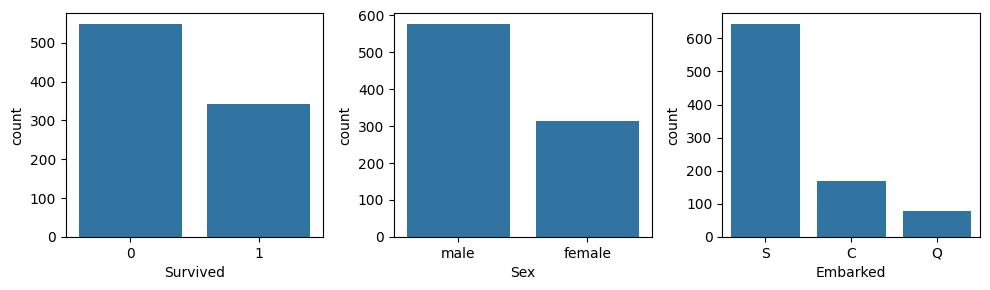

In [768]:
# categorical attributes
fig, axes = plt.subplots(figsize=(10, 3), nrows=1, ncols=3)
sns.countplot(x="Survived", data=train_df, ax=axes[0])
sns.countplot(x="Sex", data=train_df, ax=axes[1])
sns.countplot(x="Embarked", data=train_df, ax=axes[2])
fig.tight_layout()

We see that most passengers died, most were male, and most boarded at 'S' (Southampton)

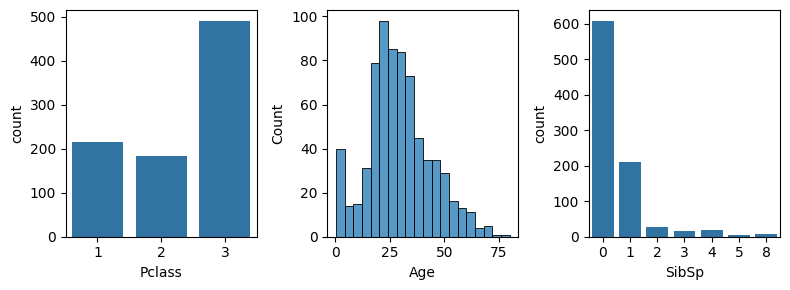

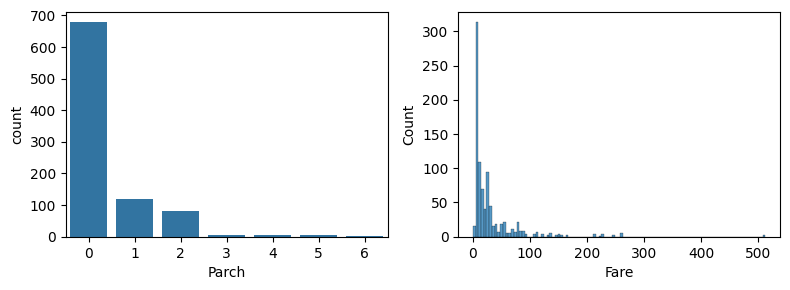

In [769]:
# numerical attributes
fig1, axes1 = plt.subplots(figsize=(8, 3), nrows=1, ncols=3)
fig2, axes2 = plt.subplots(figsize=(8, 3), nrows=1, ncols=2)
sns.countplot(x="Pclass", data=train_df, ax=axes1[0])
sns.histplot(x="Age", data=train_df, ax=axes1[1])
sns.countplot(x="SibSp", data=train_df, ax=axes1[2])
sns.countplot(x="Parch", data=train_df, ax=axes2[0])
sns.histplot(x="Fare", data=train_df, ax=axes2[1])
fig1.tight_layout()
fig2.tight_layout()

Observations
- Most passengers were in 3rd class, then 1st, then 2nd.
- Age looks normal enough.
- SibSp and Parch are right-skewed — most people had no family onboard.
- Fare is super right-skewed, so I will take the log of it (Fare_log)

## Feature Engineering

Cleaned and added engineer features like:
- `Fare_log`: log-scaled fare
- `Deck`: derived from cabin
- `Title`: parsed from name
- `High Survival Deck`: based on observed deck survival
- Convert categorical to numeric

In [770]:
train_df['Fare_log'] = np.log1p(train_df['Fare'])  # log1p avoids log(0) errors

train_df['Cabin'].fillna('Unknown', inplace=True)
train_df["Deck"] = train_df["Cabin"].str[0]

train_df["Surname Length"] = train_df["Name"].str.split(',').str[0].str.len()
train_df["Title"] = train_df["Name"].str.split(',').str[1].str.split(' ').str[1]
train_df["First Name Length"] = train_df["Name"].str.split(',').str[1].str.split(". ", regex=False).str[1].str.len()

title_mapping = {
    "Mr.": "Mr",
    "Mrs.": "Mrs",
    "Miss.": "Miss",
    "Ms.": "Miss",       # Unmarried woman (modern)
    "Mlle.": "Miss",     # French for Miss
    "Mme.": "Mrs",       # French for Mrs
    "Master.": "Master", # Usually boys under 12
    "Dr.": "Rare",       # Ambiguous — could be male or female
    "Rev.": "Rare",
    "Major.": "Rare",
    "Col.": "Rare",
    "Capt.": "Rare",
    "Sir.": "Rare",
    "Lady.": "Rare",
    "Don.": "Rare",
    "Jonkheer.": "Rare",
    "the": "Rare"
}

train_df["Title"] = train_df["Title"].map(title_mapping)

train_df['Sex'] = train_df['Sex'].map({'male':0, 'female':1})

### Initial Correlation Sweep

Before trimming any variables, I looked at how all our engineered features correlate with the target (`Survived`) This helped me:

- Spot highly correlated pairs (hinting at redundancy or multicollinearity)
- Identify low-impact or noisy features
- Decide what to keep, drop, or consolidate

To prep for this, I one-hot encoded categorical features like Deck, Embarked, and Title, then scanned the correlation heatmap to see which ones were actually useful.

In [772]:
# Manually create dummy variables for each column
deck_dummies = pd.get_dummies(train_df["Deck"], prefix="Deck")
embarked_dummies = pd.get_dummies(train_df["Embarked"], prefix="Embarked")
title_dummies = pd.get_dummies(train_df["Title"], prefix="Title")

# Concat dummy variables to the original dataframe
train_df = pd.concat([train_df, deck_dummies, embarked_dummies, title_dummies], axis=1)

<Axes: >

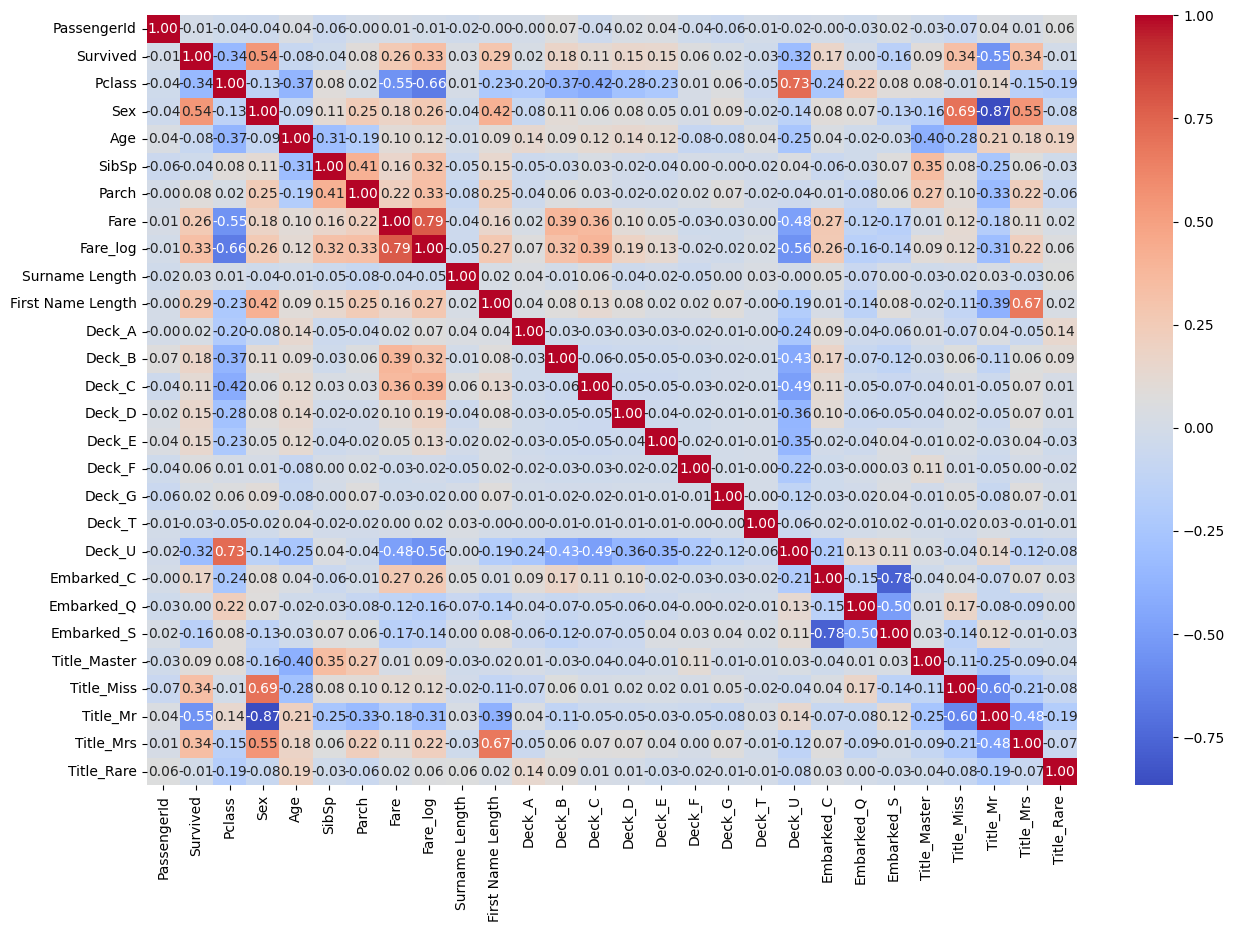

In [773]:
# Guiding Question: 'Which features are correlated with survival?' = Correlation plot

corr = train_df.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")

From the correlation matrix and some grouped stats, it looked like certain decks (especially B–E) had noticeably higher survival rates. So I double-clicked on Deck and plotted survival by deck:

(0.0, 50.0)

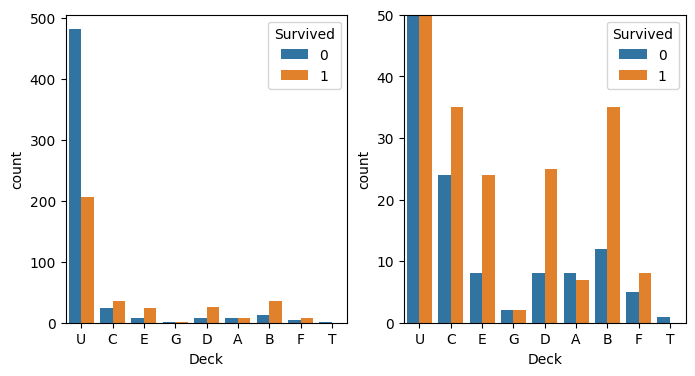

In [774]:
# Encode 
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
sns.countplot(x='Deck', hue='Survived', data=train_df, ax=ax[0])
sns.countplot(x='Deck', hue='Survived', data=train_df, ax=ax[1])
plt.ylim(top=50)

Decks B–E had way more survivors compared to others, so I created a binary feature called High Survival Deck that captures whether a passenger was on any of those decks.

Here’s what I removed after EDA + correlation checks:

- **Ticket** — didn’t seem to add meaningful info
- **Name, Cabin, and Embarked** — already used these to engineer more helpful features (e.g. Title, Deck, dummy vars)
- **Deck and all individual deck dummies** — replaced with a single High Survival Deck binary feature
- **Embarked_Q** — near-zero correlation with survival
- **Title and dummies** — only Mr/Miss/Mrs mattered, and those were kind of redundant with Sex
- **Surname Length** — had no correlation at all

In [775]:
train_df['High Survival Deck'] = (train_df['Deck_B']) | (train_df['Deck_C']) | (train_df['Deck_D']) | (train_df['Deck_E'])
train_df.drop(axis=1, columns=['Ticket', 'Name', 'Cabin', 'Embarked', 'Deck', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U', 'Embarked_Q', 'Title', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Surname Length'], inplace=True)

Then I re-ran the correlation matrix with the updated, cleaner feature set:

<Axes: >

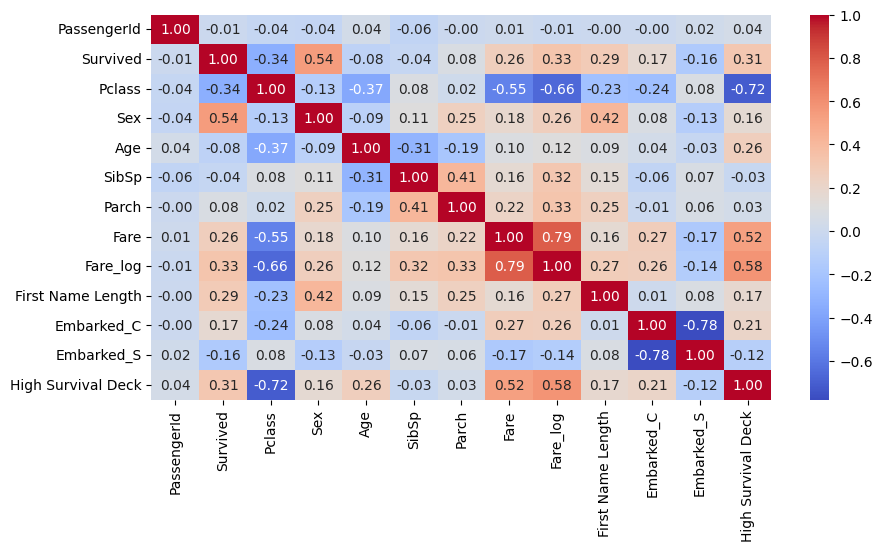

In [776]:
corr = train_df.corr()
plt.subplots(figsize=(10,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")

Only a few rows were missing Age and Fare, so I kept it simple and just filled them with the mean. I tried both mean and median — mean worked slightly better based on model accuracy, so I stuck with it.

In [777]:
train_df['Age'].fillna(train_df['Age'].mean(), inplace=True)

Train set is all set. Now I’ll run validation across models to see which performs best.

### Modeling

- 5 models: Logistic Regression, Decision Tree, Random Forest, KNN, Naive Bayes
- Optionally: SVM, Gradient Boosting, or Perceptron
- Compare accuracy, precision, recall, AUC
- Pick a best model + explain why

In [778]:
# general code to get CV score of model

def evaluate_model(model, X, y, cv=5, scoring='accuracy'):
    """Evaluate a model using cross-validation."""
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    print(f"{model} Mean: {np.mean(scores)})")
    return scores

X_train = train_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Fare_log', 'First Name Length', 'Embarked_C', 'Embarked_S', 'High Survival Deck']]
y_train = train_df['Survived']

In [779]:
# Define models
logreg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier()
dectree = DecisionTreeClassifier()
knn = KNeighborsClassifier()
nb = GaussianNB()
svm = SVC()
gradboost = GradientBoostingClassifier()
percep = Perceptron()

# Evaluate
evaluate_model(logreg, X_train, y_train)
evaluate_model(rf, X_train, y_train)
evaluate_model(dectree, X_train, y_train)
evaluate_model(knn, X_train, y_train)
evaluate_model(nb, X_train, y_train)
evaluate_model(svm, X_train, y_train)
evaluate_model(gradboost, X_train, y_train)
evaluate_model(percep, X_train, y_train)

# suppress warnings
warnings.filterwarnings("ignore")

LogisticRegression(max_iter=1000) Mean: 0.7957315924926245)
RandomForestClassifier() Mean: 0.8069801016885318)
DecisionTreeClassifier() Mean: 0.7508317117569518)
KNeighborsClassifier() Mean: 0.7026300922729269)
GaussianNB() Mean: 0.7385977025924297)
SVC() Mean: 0.6802272299290691)
GradientBoostingClassifier() Mean: 0.8260310087251271)
Perceptron() Mean: 0.6936287740882555)


Random forest performed the best overall, so that’s the model we’ll go with. FIXXXX NOW GRADIENT??

But first, here’s a quick reflection on each model we tested — and some thoughts on why they might’ve worked (or flopped) on this dataset.

### 1) Logistic Regression model

- simplest classification algo, used as baseline good starting point. fits a linear equation to input features, and then passes thru sigmoid fxn maping to 1 and 0 representing like predicted true outcome or false (in this case survival or death). strengths are that it is [easier???] to interpret - see how each feature coefficients corresponding to like strength on outcome correlation? however assumes linear relationship does not aatpure feature interactions or non linear patterns well. although there is some multicollinearity betweenfeatures(?) like pclass or fare, log reg does surprisngly well (accuracy xxx%) likely bc lots of vars map linearly with survival (e.g. sex, pclass/fare)

### 2) Decision Tree model

- description high level w figs (read articles / watch vids)
- pros and cons in general and for this dataset

[writeup]

### 3) Random Forest

- description high level w figs (read articles / watch vids)
- pros and cons in general and for this dataset

[writeup]

### 4) KNN model

- description high level w figs (read articles / watch vids)
- pros and cons in general and for this dataset

[writeup]

### 5) Naive Bayes model

- description high level w figs (read articles / watch vids)
- pros and cons in general and for this dataset

[writeup]

### 6) SVM model

- description high level w figs (read articles / watch vids)
- pros and cons in general and for this dataset

[writeup]

### 7) Gradient Boosting model

- description high level w figs (read articles / watch vids)
- pros and cons in general and for this dataset

[writeup]

### 8) Perceptron model

- description high level w figs (read articles / watch vids)
- pros and cons in general and for this dataset

[writeup]

Need to get test_df in ship shape so we can run it through our best-performing model (random forest).

In [780]:
y_train = train_df['Survived']
X_test = test_df

X_test['Fare_log'] = np.log1p(X_test['Fare'])  # log1p avoids log(0) errors
X_test['Fare_log'].fillna(X_test['Fare_log'].mean(), inplace=True) # here I tried both median and mean - mean fared better
X_test['Cabin'].fillna('Unknown', inplace=True)
X_test["Deck"] = X_test["Cabin"].str[0] # U = unknown
X_test["Surname Length"] = X_test["Name"].str.split(',').str[0].str.len()
X_test["First Name Length"] = X_test["Name"].str.split(',').str[1].str.split(". ", regex=False).str[1].str.len()
X_test['Sex'] = X_test['Sex'].map({'male':0, 'female':1})
X_test = pd.get_dummies(X_test, columns=["Embarked"])
X_test['High Survival Deck'] = (X_test['Deck'].isin(['B', 'C', 'D', 'E'])).astype(int)
X_test = X_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Fare_log', 'First Name Length', 'Embarked_C', 'Embarked_S', 'High Survival Deck']]

In [781]:
# !pip install scikit-learn --> add this to enviro? FIX

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

submission = pd.read_csv('titanic/gender_submission.csv')
submission['Survived'] = y_pred # answer to 'Can we accurately predict survival with a simple model?' ys got to 77.x%!

In [782]:
submission.to_csv('submissions/final_version.csv', index=None)

### Feature Importance chart

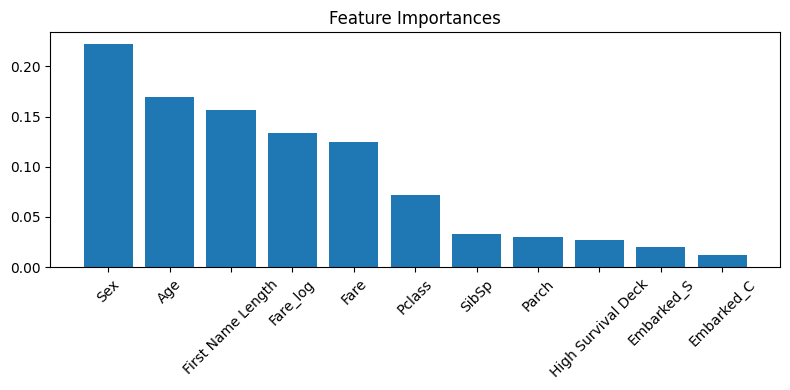

In [783]:
importances = model.feature_importances_
features = X_train.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 4))
plt.title("Feature Importances")
plt.bar(range(len(features)), importances[indices], align="center")
plt.xticks(range(len(features)), features[indices], rotation=45)
plt.tight_layout()
plt.show()

Sex was by far the strongest predictor, as expected. FIX REST

### Final Thoughts & What I Learned FIXXXX
Even though the Titanic dataset is a classic, it was super valuable to go through the full data science pipeline myself — from messy raw data to model evaluation.

Some things I really enjoyed:
- Using EDA to guide feature engineering (like flagging high-survival decks)
- Trying different ways of handling missing values (mean vs. median)
- Testing out a bunch of classifiers and seeing what worked best
- Seeing how even small decisions (like which features to drop or how to encode) shifted performance

With more time, I’d:
- Consider dropping or deprioritizing very low-importance features like Embarked_C and Embarked_S in future models.


[fix theses]
Tune hyperparameters (e.g. with grid/random search)
- Try ensemble methods or advanced models like XGBoost
- Visualize model confidence or misclassified examples
- Test how the model performs across different passenger subgroups (e.g. did it do better for women/kids?)

# References
- Titanic - Machine Learning from Disaster [https://www.kaggle.com/competitions/titanic/data]
- Titanic (wikipedia) [https://en.wikipedia.org/wiki/Titanic]
- cleaning data [https://www.youtube.com/watch?v=cWf08xuSqdU&ab_channel=DataGeekismyname]